In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vincent
%matplotlib inline

In [6]:
aisles = pd.read_csv("C:\Users\kj.park\Desktop\Class\Instacart/aisles.csv")
#order_products_prior = pd.read_csv("C:\Users\kj.park\Desktop\Class\Instacart/order_products__prior.csv")
#Question: What to do when there are memory limits?
orders = pd.read_csv("C:\Users\kj.park\Desktop\Class\Instacart/orders.csv")
products = pd.read_csv("C:\Users\kj.park\Desktop\Class\Instacart/products.csv")
order_products_train = pd.read_csv("C:\Users\kj.park\Desktop\Class\Instacart/order_products__train.csv")
departments = pd.read_csv("C:\Users\kj.park\Desktop\Class\Instacart/departments.csv")

In [7]:
#Provides Grocery Aisle information (like a mappings table)
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [8]:
#Evaluating order data
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Interestingly, there are order_hour_of_day and order_dow to see what time and day people order the most, so I will expand on that through visualizations:

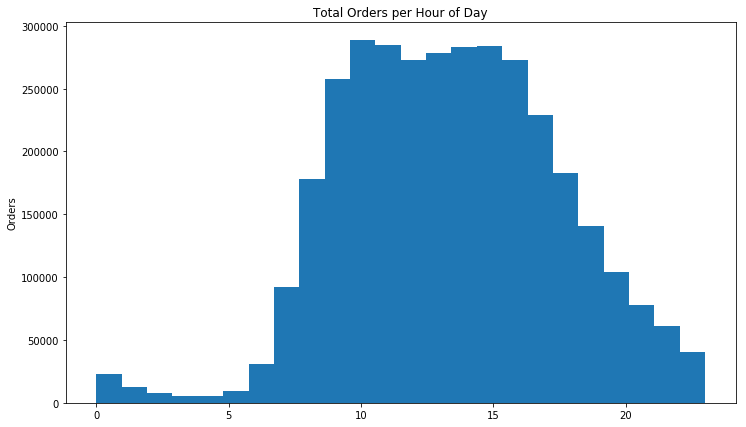

In [22]:
plt.figure(figsize={12,7})
plt.hist(orders['order_hour_of_day'], bins = 24)
plt.ylabel('Orders')
plt.title('Total Orders per Hour of Day')
 
plt.show()

Looks about standard for a workday and the order frequencies occur most during the standard work hours. Let's see at what frequency people order during each day:

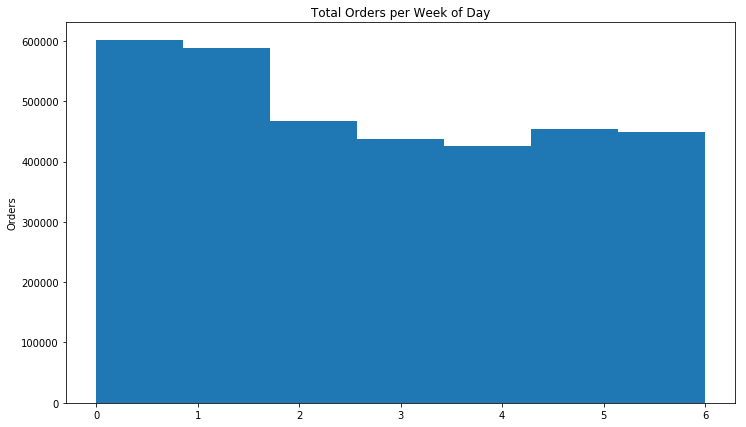

In [59]:
plt.figure(figsize={12,7})
plt.hist(orders['order_dow'], bins=7)
plt.ylabel('Orders')
plt.title('Total Orders per Week of Day')
 
plt.show()

It appears that most orders occur on the weekends. We can assume then that the most popular times to order are 10AM to 3PM while the most popular days to order are Sunday and Saturday.

In [16]:
products_aisles_department.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks


In [ ]:
products_aisles = pd.merge(products, aisles, on='aisle_id')
products_aisles_department = pd.merge(products_aisles, departments, on ='department_id')

In [19]:
order_products_train.head()
#add_t0_cart_order = how many of productid added to cart.
#reordered = boolean statement to see if this is another order from the same customer


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
